In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix 
from scikitplot.metrics import plot_roc
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [71]:
plt.rcParams['figure.dpi']=200

In [2]:
df_train=pd.read_csv('RavdessAudioOnlyFeatures_TRAIN.csv')
df_test=pd.read_csv('RavdessAudioOnlyFeatures_TEST.csv')

In [3]:
df_train.drop(['modality', 'actor','repetition', 'filename'], axis=1, inplace=True)

df_test.drop(['modality', 'actor','repetition', 'filename'], axis=1, inplace=True)


In [4]:
#mapping 
vc_map= {'speech':0, 'song':1}
emo_int_map={'normal':0, 'strong':1}
state_map= {'Kids are talking by the door':0,'Dogs are sitting by the door':1}
sex_map={'M':0, 'F':1}
emo_map={'angry':0,'calm':1,'disgust':2, 'fearful':3, 'happy':4, 
'neutral': 5, 'sad':6, 'surprised':7  }

df_train.replace({'vocal_channel':vc_map,'emotional_intensity':emo_int_map,
'emotion':emo_map, 'statement':state_map,'sex':sex_map },inplace=True)

df_test.replace({'vocal_channel':vc_map,'emotional_intensity':emo_int_map,
'emotion':emo_map, 'statement':state_map,'sex':sex_map },inplace=True)


In [5]:
x_train=df_train.drop('emotion', axis=1)
x_test= df_test.drop('emotion', axis=1)
y_train= df_train['emotion']
y_test= df_test['emotion']

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [7]:
sc=StandardScaler()

x_train_norm=sc.fit_transform(x_train)
x_test_norm=sc.transform(x_test)

In [24]:
clf_base=LogisticRegression(max_iter=1000000, penalty='l1', solver='liblinear')
clf_base.fit(x_train_norm, y_train)

LogisticRegression(max_iter=1000000, penalty='l1', solver='liblinear')

In [25]:
print(f'Train_acc is {accuracy_score(y_train, clf_base.predict(x_train_norm))}')
print(classification_report(y_test, clf_base.predict(x_test_norm) ))

Train_acc is 0.8637855579868708
              precision    recall  f1-score   support

           0       0.56      0.76      0.65        96
           1       0.52      0.66      0.58        96
           2       0.46      0.69      0.55        48
           3       0.62      0.42      0.50        96
           4       0.37      0.39      0.38        96
           5       0.43      0.42      0.42        48
           6       0.44      0.18      0.25        96
           7       0.45      0.48      0.46        48

    accuracy                           0.49       624
   macro avg       0.48      0.50      0.47       624
weighted avg       0.49      0.49      0.47       624



In [8]:
clf_b=LogisticRegression(random_state=44, max_iter=1000, solver='liblinear', C=0.05, penalty='l1') 
clf_b.fit(x_train_norm, y_train)


LogisticRegression(C=0.05, max_iter=1000, penalty='l1', random_state=44,
                   solver='liblinear')

In [52]:
print(accuracy_score(y_train, clf_b.predict(x_train_norm)))

0.6061269146608315


In [76]:
y_pred=clf_b.predict(x_test_norm)

print(f'Train_acc is {accuracy_score(y_train, clf_b.predict(x_train_norm))}')
print(classification_report(y_test, y_pred))

Train_acc is 0.6148796498905909
              precision    recall  f1-score   support

           0       0.53      0.84      0.65        96
           1       0.51      0.74      0.60        96
           2       0.55      0.65      0.60        48
           3       0.61      0.32      0.42        96
           4       0.39      0.44      0.41        96
           5       0.67      0.29      0.41        48
           6       0.52      0.27      0.36        96
           7       0.45      0.44      0.44        48

    accuracy                           0.51       624
   macro avg       0.53      0.50      0.49       624
weighted avg       0.52      0.51      0.49       624



In [11]:
def coefficients(model, target, data):
    

    if target=='all':

        d={'Attribute': data.columns, 
           'Coef_angry': model.coef_.tolist()[0],
           'Coef_calm': model.coef_.tolist()[1], 
           'Coef_disgust': model.coef_.tolist()[2],
           'Coef_fearful': model.coef_.tolist()[3],
           'Coef_happy': model.coef_.tolist()[4],
           'Coef_neutral': model.coef_.tolist()[5],
           'Coef_sad': model.coef_.tolist()[6],
           'Coef_surprised': model.coef_.tolist()[7]}
        interp=pd.DataFrame(data=d)
        return interp
    
    else:
        d={'Attribute': data.columns, 
           'Coef': model.coef_.tolist()[target]}
        interp= pd.DataFrame(data=d)
        
        return interp.sort_values(by='Coef')

In [98]:
coefficients(clf_b, 1, x_train)

,Attribute,Coef
272,kur_w3,-0.062271
0,vocal_channel,-0.059112
332,stft_std_w3,-0.055048
50,mfcc_min,-0.054261
47,mfcc_sum,-0.053451
...,...,...
300,zc_kur_w3,0.050567
3,sex,0.054862
308,mfcc_q05_w3,0.054926
227,mfcc_q95_w2,0.057450


In [113]:
test_acc_l1= []
train_acc_l1=[]
coefs=np.linspace(0.0001, 0.5, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=10000, C=c, penalty='l1', solver='liblinear')
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l1.append(tr)
    test_acc_l1.append(tst)


In [114]:
test_acc_l2= []
train_acc_l2=[]
coefs=np.linspace(0.0001, 0.5, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=10000, penalty='l2', C=c)
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l2.append(tr)
    test_acc_l2.append(tst)

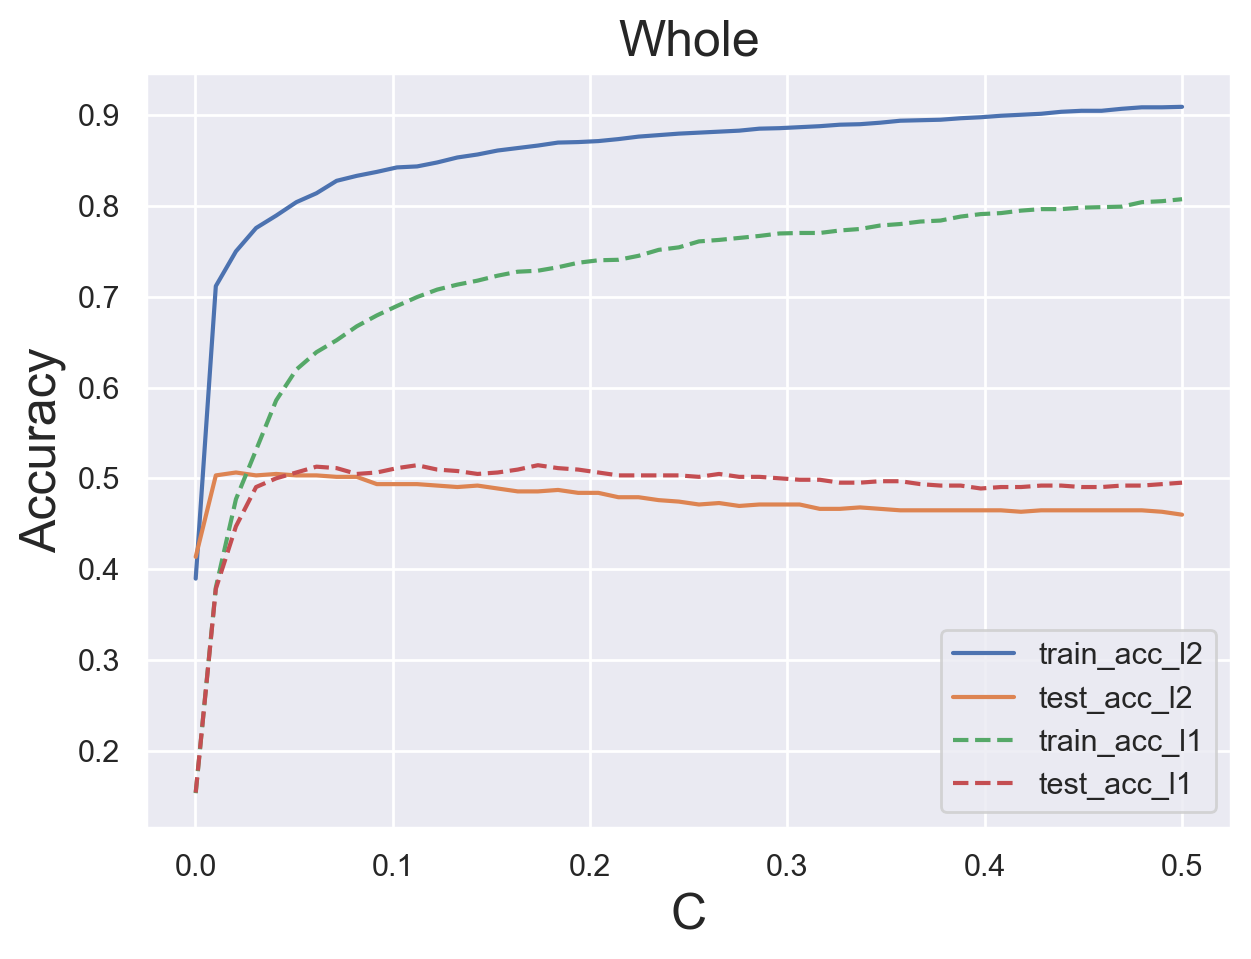

In [115]:
sns.set()
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.plot(coefs,train_acc_l2, label='train_acc_l2')
plt.plot(coefs, test_acc_l2, label='test_acc_l2')
plt.plot(coefs,train_acc_l1, label='train_acc_l1', linestyle="--")
plt.plot(coefs, test_acc_l1, label='test_acc_l1', linestyle="--")
plt.xlabel('C', )
plt.ylabel('Accuracy')
plt.title('Whole')
plt.legend()


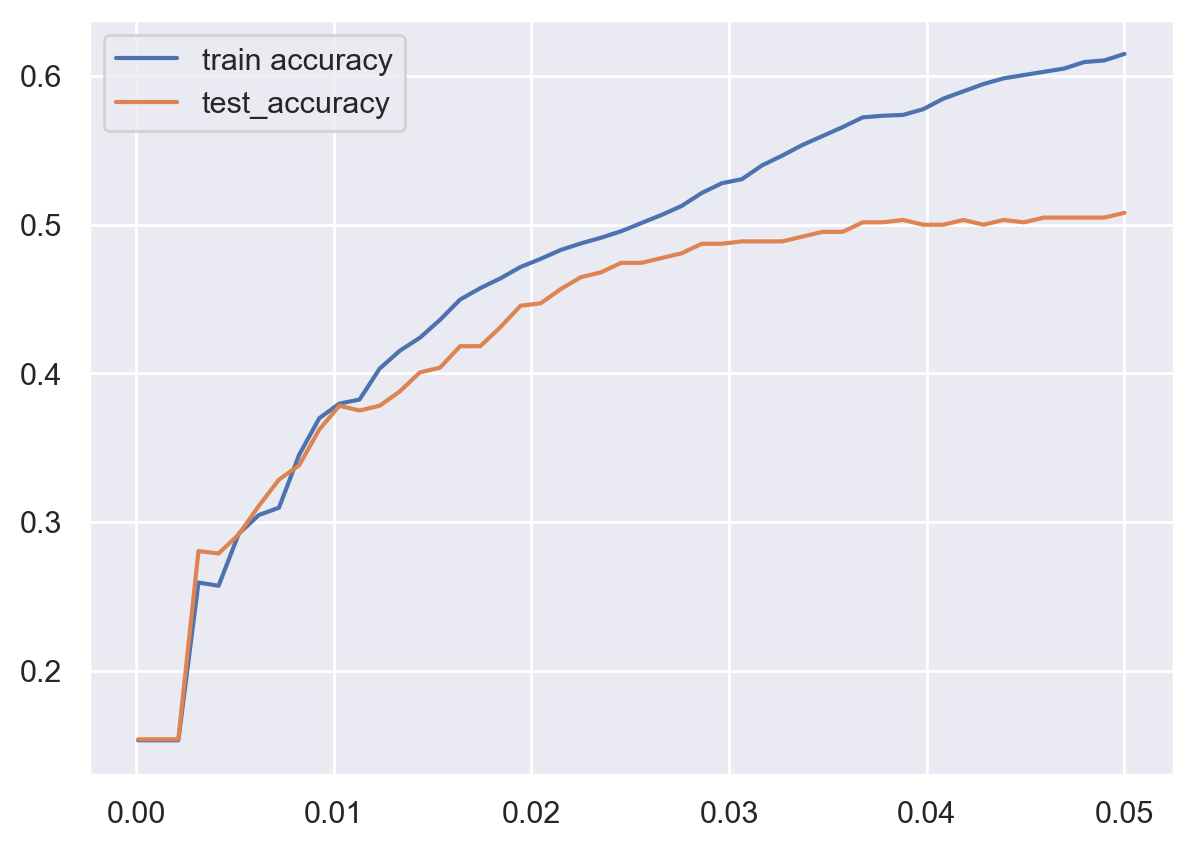

In [116]:
test_acc_l1= []
train_acc_l1=[]
coefs=np.linspace(0.0001, 0.05, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=10000, C=c, penalty='l1', solver='liblinear')
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l1.append(tr)
    test_acc_l1.append(tst)


plt.plot(coefs,train_acc_l1, label='train accuracy')
plt.plot(coefs, test_acc_l1, label='test_accuracy')
plt.legend()

In [117]:
test_acc_l2= []
train_acc_l2=[]
coefs=np.linspace(0.0001, 0.05, 50).tolist()

for c in coefs:
    clf=LogisticRegression(random_state=44 ,max_iter=10000, penalty='l2', C=c)
    clf.fit(x_train_norm, y_train)
    tr=accuracy_score(y_train, clf.predict(x_train_norm))
    tst=accuracy_score(y_test, clf.predict(x_test_norm))
    train_acc_l2.append(tr)
    test_acc_l2.append(tst)

In [125]:
plt.rcParams['figure.dpi']=200

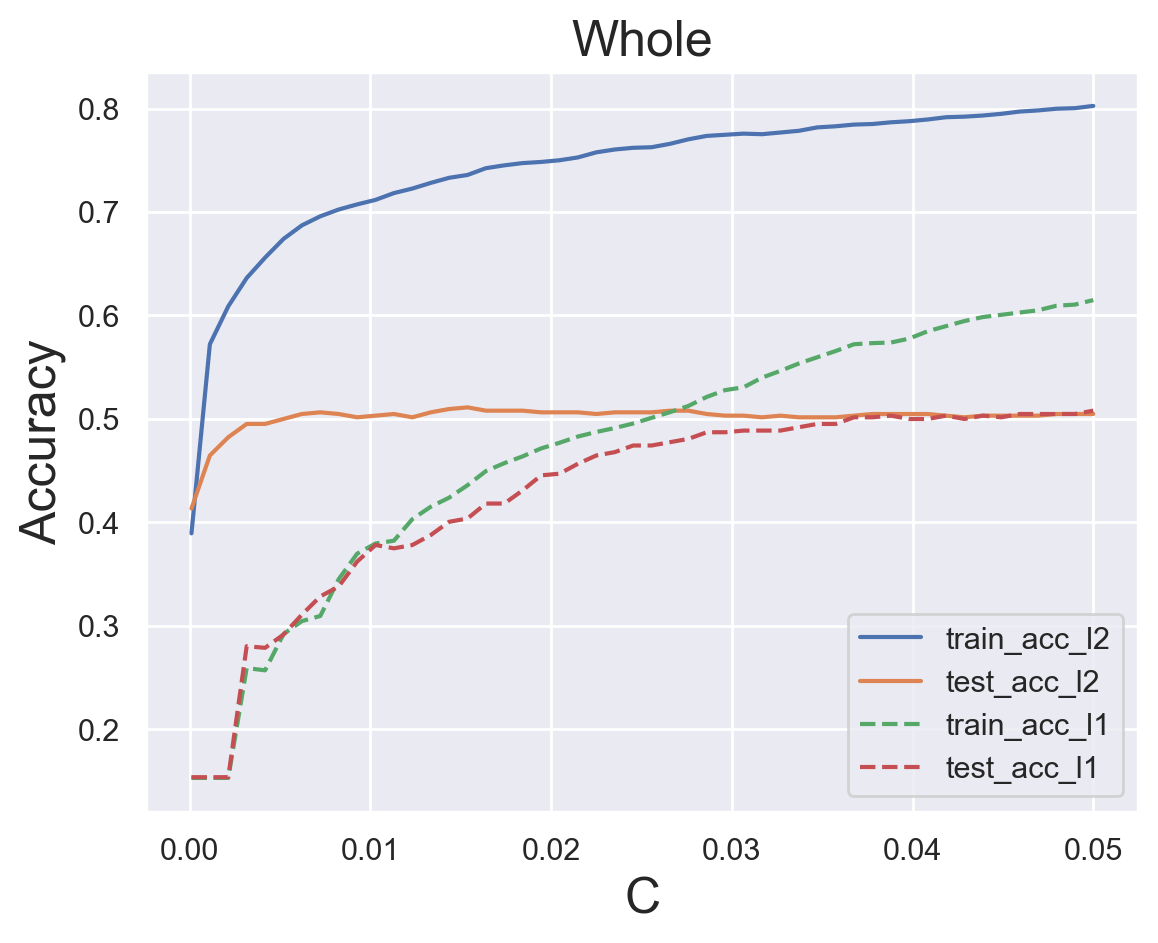

In [126]:
sns.set()

plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.plot(coefs,train_acc_l2, label='train_acc_l2')
plt.plot(coefs, test_acc_l2, label='test_acc_l2')
plt.plot(coefs,train_acc_l1, label='train_acc_l1', linestyle="--")
plt.plot(coefs, test_acc_l1, label='test_acc_l1', linestyle="--")
plt.xlabel('C', )
plt.ylabel('Accuracy')
plt.title('Whole')
plt.legend()

In [77]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.03, 0.06, 30), # the range is on smaller values since these models are more overfitted
    'solver' : ['liblinear']}

grid= GridSearchCV(
    LogisticRegression(random_state=44, max_iter=10000),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0, n_repeats=5),
    n_jobs=-1,
    refit=True)

grid.fit(x_train_norm, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=0),
             estimator=LogisticRegression(max_iter=10000, random_state=44),
             n_jobs=-1,
             param_grid={'C': array([0.03      , 0.03103448, 0.03206897, 0.03310345, 0.03413793,
       0.03517241, 0.0362069 , 0.03724138, 0.03827586, 0.03931034,
       0.04034483, 0.04137931, 0.04241379, 0.04344828, 0.04448276,
       0.04551724, 0.04655172, 0.04758621, 0.04862069, 0.04965517,
       0.05068966, 0.05172414, 0.05275862, 0.0537931 , 0.05482759,
       0.05586207, 0.05689655, 0.05793103, 0.05896552, 0.06      ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [78]:
opt_log=grid.best_estimator_
print(grid.best_params_,grid.best_score_)

{'C': 0.05793103448275862, 'penalty': 'l2', 'solver': 'liblinear'} 0.6057995358934052


{'C': 0.003, 'penalty': 'l2', 'solver': 'liblinear'} 0.5305307283479304, l2 optimal

In [101]:
print(accuracy_score(y_test,opt_log.predict(x_test_norm)))
print(accuracy_score(y_train,opt_log.predict(x_train_norm)))

0.5192307692307693
0.7647702407002188


In [9]:
opt_log=LogisticRegression(C=0.003, max_iter=10000, solver='liblinear')

In [11]:
%%timeit
opt_log.fit(x_train_norm, y_train)

1.53 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
print(classification_report(y_test,opt_log.predict(x_test_norm)))
print(accuracy_score(y_test,opt_log.predict(x_test_norm)))
print(accuracy_score(y_train,opt_log.predict(x_train_norm)))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65        96
           1       0.49      0.62      0.55        96
           2       0.49      0.58      0.53        48
           3       0.62      0.36      0.46        96
           4       0.41      0.47      0.44        96
           5       0.52      0.35      0.42        48
           6       0.42      0.31      0.36        96
           7       0.48      0.42      0.44        48

    accuracy                           0.50       624
   macro avg       0.50      0.49      0.48       624
weighted avg       0.50      0.50      0.49       624

0.4951923076923077
0.6334792122538293


In [84]:
df_trial=pd.read_csv('RavdessAudioOnlyFeatures_TEST.csv')
y_test_label=df_trial['emotion']

In [91]:
plt.rcParams['figure.figsize']=(5,4)

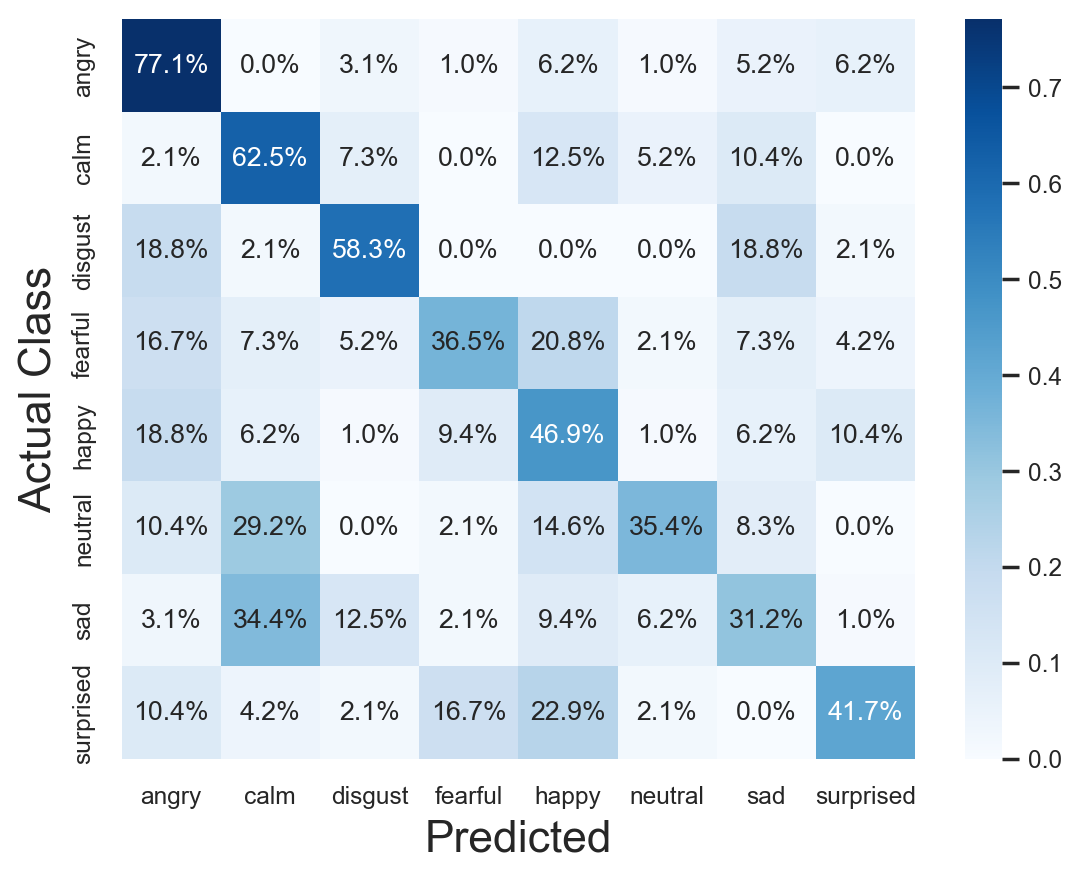

In [131]:
emo_labels=['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
sns.set(font_scale=0.8)
conf_m= confusion_matrix(y_test, opt_log.predict(x_test_norm), normalize='true')
sns.heatmap(conf_m, annot=True, xticklabels=emo_labels, yticklabels=emo_labels, fmt='.1%', cmap='Blues')
plt.xlabel("Predicted", fontsize=16)
plt.ylabel("Actual Class", fontsize=16)
plt.show()

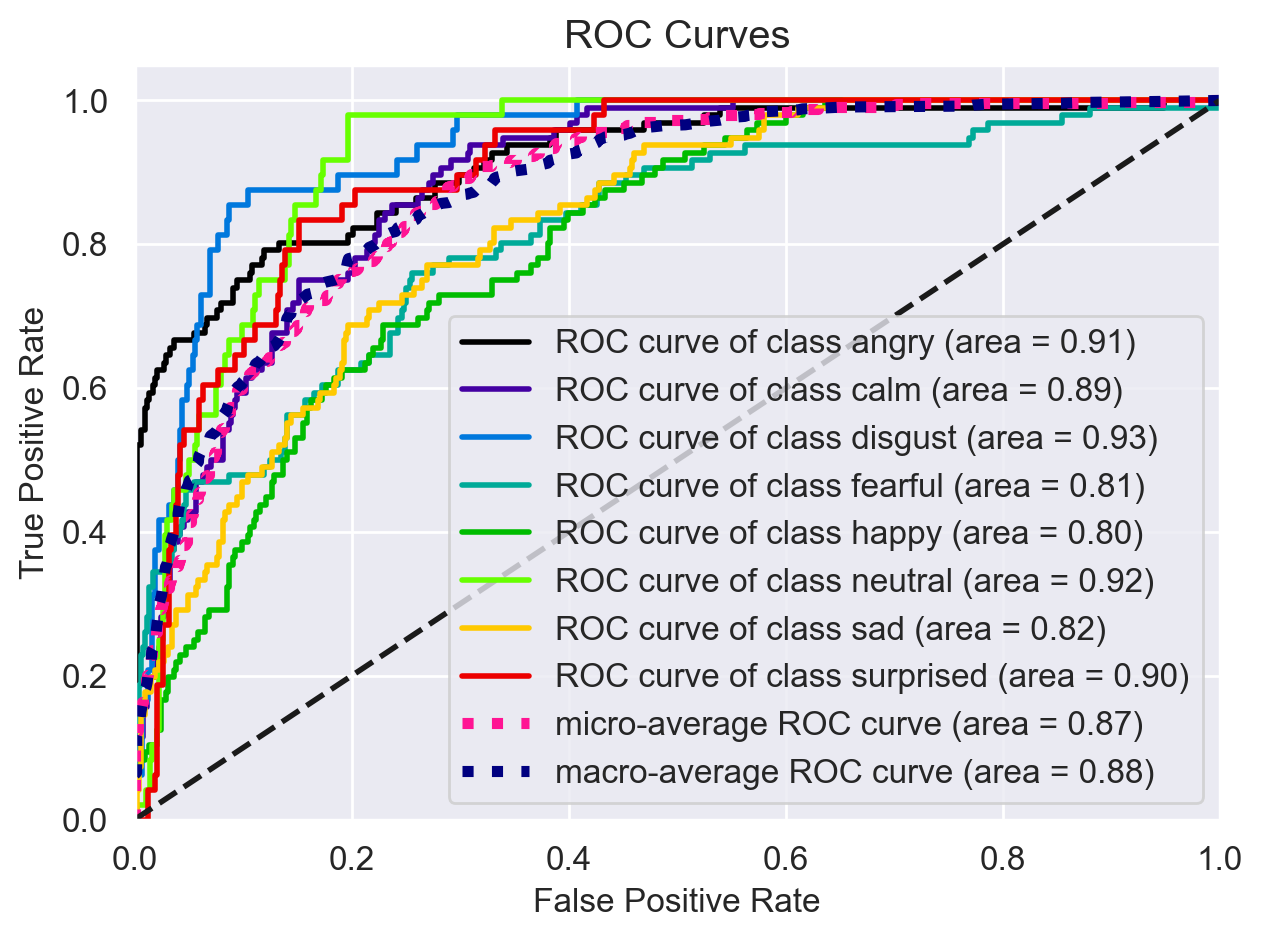

In [112]:
plt.rcParams["figure.figsize"] = (7,5)
sns.set(font_scale=1)
plot_roc(y_test_label, opt_log.predict_proba(x_test_norm))
plt.show()

In [132]:
from sklearn.metrics import roc_auc_score

In [135]:
roc_auc_score(y_test, opt_log.predict_proba(x_test), multi_class='ovo')

c:\Users\valif\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.5027979290674603

In [28]:
df_coef=coefficients(clf_base, 'all', x_train)
df_coef

,Attribute,Coef_angry,Coef_calm,Coef_disgust,Coef_fearful,Coef_happy,Coef_neutral,Coef_sad,Coef_surprised
0,vocal_channel,0.924191,-0.546944,-1.923486,2.916231,-0.883001,1.285366,0.235826,-0.256618
1,emotional_intensity,-2.883686,0.995581,0.049414,-0.636300,-0.116688,-2.102366,0.464840,0.842452
2,statement,-0.649360,0.056778,-0.160091,0.128220,0.000000,0.039981,-0.294902,-0.517280
3,sex,1.088451,1.651075,0.084834,-0.108394,-0.195371,0.650677,-0.871834,-0.124891
4,frame_count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
424,stft_q75_w4,0.000000,-0.189057,-0.203052,0.108995,0.000000,0.000000,0.314598,0.000000
425,stft_q95_w4,0.000000,0.000000,0.026723,0.056844,0.000000,0.000000,0.000000,0.000000
426,stft_q99_w4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
427,stft_kur_w4,0.000000,0.000000,0.000000,0.000000,-0.077030,0.002678,-0.289432,0.094026


In [26]:
df_coef['Coef_sad'].value_counts()[0]

51

In [29]:
for col in df_coef.columns.tolist()[1:]:
    
    count = df_coef[col].value_counts()[0]
    print(f'zeros in {col}: {count}')


zeros in Coef_angry: 283
zeros in Coef_calm: 260
zeros in Coef_disgust: 286
zeros in Coef_fearful: 223
zeros in Coef_happy: 219
zeros in Coef_neutral: 299
zeros in Coef_sad: 238
zeros in Coef_surprised: 294


In [40]:
log_trial=LogisticRegression(C= 0.003, penalty= 'l1', solver = 'liblinear')
log_trial.fit(x_train_norm, y_train)

print(f'train acc:{accuracy_score(y_train, log_trial.predict(x_train_norm))}')
print(classification_report(y_test, log_trial.predict(x_test_norm)))

train acc:0.2587527352297593
              precision    recall  f1-score   support

           0       0.37      0.82      0.51        96
           1       0.23      1.00      0.38        96
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        96
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        96
           7       0.00      0.00      0.00        48

    accuracy                           0.28       624
   macro avg       0.08      0.23      0.11       624
weighted avg       0.09      0.28      0.14       624



c:\Users\valif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\valif\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:

df_coef_trial=coefficients(opt_log, 'all', x_train)
df_coef_trial

,Attribute,Coef_angry,Coef_calm,Coef_disgust,Coef_fearful,Coef_happy,Coef_neutral,Coef_sad,Coef_surprised
0,vocal_channel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,emotional_intensity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,statement,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,sex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,frame_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
424,stft_q75_w4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,stft_q95_w4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,stft_q99_w4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
427,stft_kur_w4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
for col in df_coef_trial.columns.tolist()[1:]:
    
    count = df_coef_trial[col].value_counts()[0]
    print(f'zeros in {col}: {count}')


zeros in Coef_angry: 428
zeros in Coef_calm: 429
zeros in Coef_disgust: 429
zeros in Coef_fearful: 429
zeros in Coef_happy: 429
zeros in Coef_neutral: 429
zeros in Coef_sad: 429
zeros in Coef_surprised: 429


In [52]:
def getVifs(data):


    vifs=[]

    for i in range (len(data.columns)):
        vif= variance_inflation_factor(data.values, i)
        vifs.append(vif)

    vif_data_dict={'feature':data.columns, 'vif': vifs}
    vif_data=pd.DataFrame(data=vif_data_dict)
    return vif_data


In [ ]:
x_train_vif=x_train.copy()
discarded=[] #discarded features


vif_data=getVifs(x_train_vif) #first dataset with vif for each feature 

max_vif= vif_data['vif'].max()

while max_vif >= 10: #want the max vif to be 5
    
    worst_feat=vif_data['feature'][vif_data['vif']==max_vif].values[0] # worst feature (highest vif) for current dataset
    x_train_vif.drop(worst_feat, axis=1, inplace=True)
    discarded.append(worst_feat)
    vif_data = getVifs(x_train_vif)
    max_vif= vif_data['vif'].max()

vif_data
